In [1]:
import torch 
import numpy as np

import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.io as pio
import matplotlib.pyplot as plt
from IPython.display import display, Image

import optuna
from optuna import trial

from functions import rastrigin, adam_optimizer, sgd_optimizer, BBI_optimizer

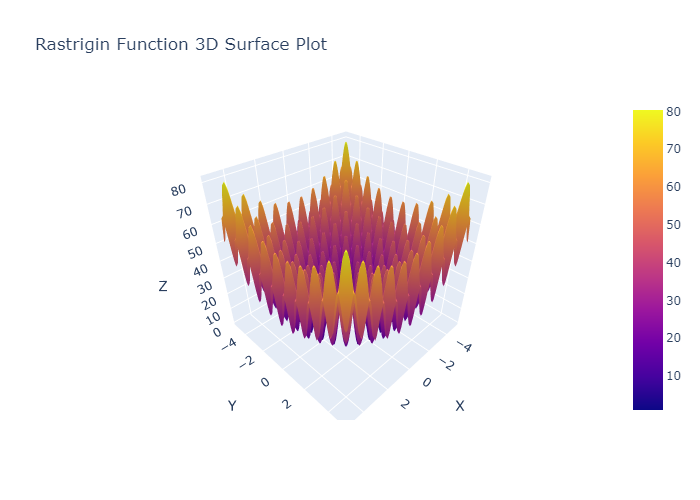

In [2]:
def rastrigin_plot(x, A=10):
    D = len(x)
    f = A*D + np.sum(x**2 - A*np.cos(2*np.pi*x))
    df = 2*x + 2*A*np.pi*np.sin(2*np.pi*x)
    return f, df

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros((len(X), len(Y)))
for i in range(100):
    for j in range(100):
        Z[i,j] = rastrigin_plot(np.array([X[i,j], Y[i,j]]))[0]

fig = go.Figure(data=[go.Surface(x=X, y=Y, z=Z)])
fig.update_layout(
    title='Rastrigin Function 3D Surface Plot',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',))
pyo.plot(fig, filename='plotly/rastrigin-function-3D-surface-plot.html')
pio.write_image(fig, 'plotly/rastrigin-function-3D-surface-plot.png')
display(Image(filename='plotly/rastrigin-function-3D-surface-plot.png'))

[View Rastrigin function made in Plotly](https://github.com/dariayakovchuk/Optimization-Mini-Project/plotly/rastrigin-function-3D-surface-plot.html)

In [3]:
n = 10
global_min = torch.zeros(n)
xs = torch.tensor([-4.0, 3.0])

print("Initial value: ", rastrigin(xs)[0])
print("Global minimum: ", rastrigin(global_min)[0])

Initial value:  tensor(25.)
Global minimum:  tensor(0.)


In [4]:
# Tuning function with optuna

tune_iterations = 2500 
n_trials = 50
test_iterations = 4 * tune_iterations
x0 =xs.tolist()

potential = rastrigin
optuna.logging.disable_default_handler()

def hyper_tuning(ranges, ranges_integer, optimizer, tune_iterations=1000, n_trials=100, **fixed_pars):
    def optimizer_func(trial):
        pars = {}
        for par, range in ranges.items(): pars[par] = trial.suggest_float(par, *range)
        for par, range in ranges_integer.items(): pars[par] = trial.suggest_int(par, *range)
        xs, _, _ = optimizer(x0, potential, iterations=tune_iterations, **pars, **fixed_pars)
        return potential(xs)[0]
    study = optuna.create_study(direction='minimize')
    study.optimize(optimizer_func, n_trials=n_trials)
    best = study.best_params
    loss = study.best_value
    return best, loss

best_par_sgd, loss_sgd = hyper_tuning({'lr': [1e-10,.5], 'momentum': [0,1.0]}, {}, sgd_optimizer, tune_iterations=tune_iterations, n_trials=n_trials)
print("sgd:", best_par_sgd, "\t loss:", loss_sgd)

sgd: {'lr': 0.049773408488001505, 'momentum': 0.439330151794727} 	 loss: 0.2681312561035156


In [5]:
best_par_adam, loss_adam = hyper_tuning({'lr': [1e-10,.5]},{}, adam_optimizer, tune_iterations=tune_iterations, n_trials=n_trials)
print("adam:", best_par_adam, "\t loss:", loss_adam)

adam: {'lr': 0.49964580047219087} 	 loss: 4.974788665771484


In [15]:
best_par_bbi, loss_bbi = hyper_tuning({'lr': [1e-6,1e-1]},{}, BBI_optimizer, tune_iterations=tune_iterations,  n_trials=n_trials*4,
    threshold0 = 40, threshold = 100, deltaEn = 2.0, v0 = 1e-1,  n_fixed_bounces = 4, consEn = True)
print("bbi:", best_par_bbi, "\t loss:", loss_bbi)

bbi: {'lr': 0.09644257537357} 	 loss: 0.017293930053710938


Loss adam: 4.974788665771484
Loss sgd: 0.2681312561035156
Loss bbi: 0.0595550537109375


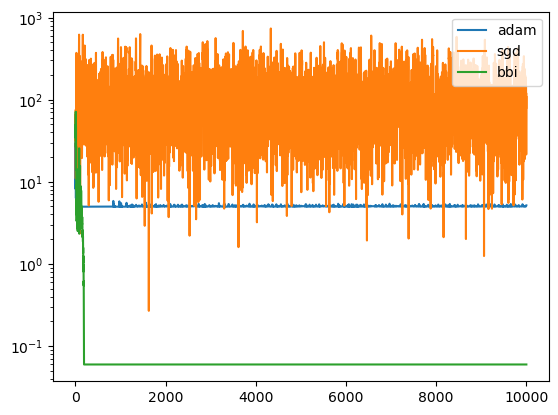

In [17]:
best_par_bbi['deltaEn'] = 2.0
best_par_bbi['v0'] = 1e-1
best_par_bbi['threshold0'] = 40
best_par_bbi['threshold'] = 100
best_par_bbi['n_fixed_bounces'] = 4
best_par_bbi['consEn'] = True

x0 =xs.tolist()
_, xslist_bbi, _ = BBI_optimizer(x0, potential, iterations=test_iterations, **best_par_bbi)
_, xslist_adam, _ = adam_optimizer(x0, potential, iterations=test_iterations, **best_par_adam)
_, xslist_sgd, _ = sgd_optimizer(x0, potential, iterations=test_iterations, **best_par_sgd)

name = ["adam", "sgd", "bbi"]
n = 0
for lists in [xslist_adam, xslist_sgd, xslist_bbi]:
    min_temp = 10e20
    for elem in lists:
        elem_tens_val, _ = rastrigin(torch.tensor(elem))
        if elem_tens_val < min_temp:
            min_temp = elem_tens_val.item()
    print(f"Loss {name[n]}: {min_temp}")
    n += 1

def plotting(f, lists, names):
    n = 0
    for xs_list in lists:
        val = []
        for point in xs_list:
            val.append(f(torch.tensor(point))[0])
        val = torch.stack(val)
        plt.plot(val, label = f"{names[n]}")
        n += 1
    plt.yscale("log")
    plt.legend()
    plt.show()

plotting(rastrigin, [xslist_adam, xslist_sgd, xslist_bbi], ["adam", "sgd", "bbi"])

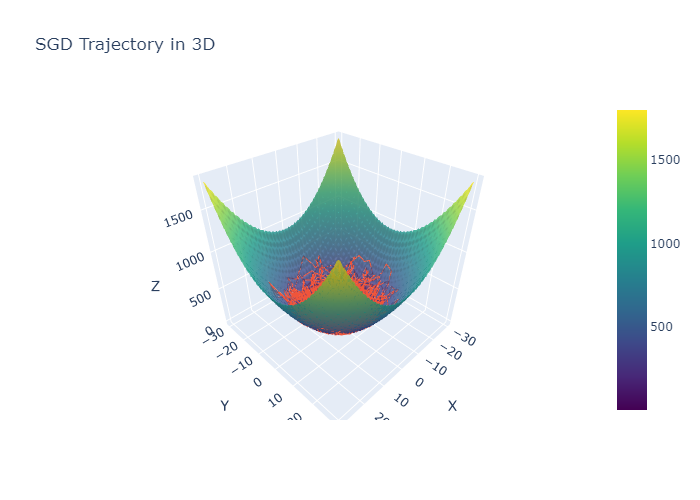

In [18]:
best, xslist_sgd, trajectory = sgd_optimizer(x0, potential, iterations=test_iterations, **best_par_sgd)

# surface data
x = np.linspace(-30, 30, 100)
y = np.linspace(-30, 30, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        Z[i,j] = rastrigin_plot(np.array([X[i,j], Y[i,j]]))[0]

# Create the trajectory
trajectory_x = [pos[0] for pos in trajectory]
trajectory_y = [pos[1] for pos in trajectory]
trajectory_z = [rastrigin_plot(np.array([pos[0], pos[1]]))[0] for pos in trajectory]

surface = go.Surface(x=X, y=Y, z=Z, colorscale='Viridis', opacity=0.8)
trajectory = go.Scatter3d(x=trajectory_x, y=trajectory_y, z=trajectory_z, mode='lines', marker=dict(size=4))
layout = go.Layout(scene=dict(xaxis=dict(title='X'), yaxis=dict(title='Y'), zaxis=dict(title='Z')), title='SGD Trajectory in 3D')
fig = go.Figure(data=[surface, trajectory], layout=layout)
pyo.plot(fig, filename='plotly/Rastrigin-SGD-trajectory-in-3D.html')
pio.write_image(fig, 'plotly/Rastrigin-SGD-trajectory-in-3D.png')
display(Image(filename='plotly/Rastrigin-SGD-trajectory-in-3D.png'))

[View SGD performans on Rastrigin function made in Plotly](https://github.com/dariayakovchuk/Optimization-Mini-Project/plotly/Rastrigin-SGD-trajectory-in-3D.html)

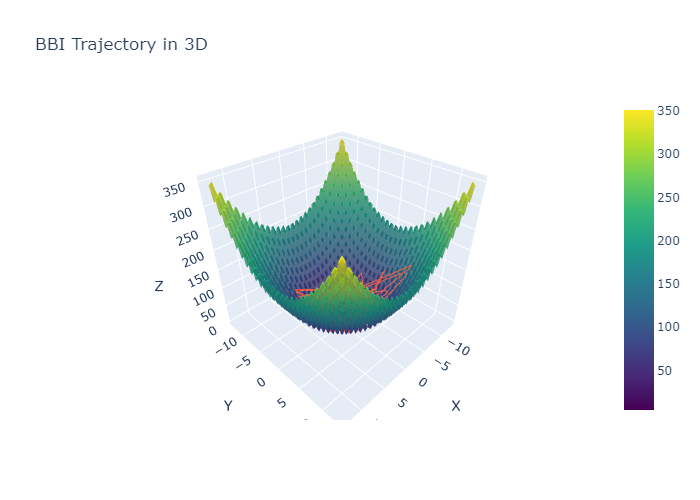

In [19]:
x0 =xs.tolist()
best, xslist_bbi, trajectory = BBI_optimizer(x0, potential, iterations=test_iterations, **best_par_bbi)

# surface data
x = np.linspace(-13, 13, 100)
y = np.linspace(-13, 13, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        Z[i,j] = rastrigin_plot(np.array([X[i,j], Y[i,j]]))[0]

# Create the trajectory
trajectory_x = [pos[0] for pos in trajectory]
trajectory_y = [pos[1] for pos in trajectory]
trajectory_z = [rastrigin_plot(np.array([pos[0], pos[1]]))[0] for pos in trajectory]

surface = go.Surface(x=X, y=Y, z=Z, colorscale='Viridis', opacity=0.8)
trajectory = go.Scatter3d(x=trajectory_x, y=trajectory_y, z=trajectory_z, mode='lines', marker=dict(size=4))
layout = go.Layout(scene=dict(xaxis=dict(title='X'), yaxis=dict(title='Y'), zaxis=dict(title='Z')), title='BBI Trajectory in 3D')
fig = go.Figure(data=[surface, trajectory], layout=layout)
pyo.plot(fig, filename='plotly/Rastrigin-BBI-trajectory-in-3D.html')
pio.write_image(fig, 'plotly/Rastrigin-BBI-trajectory-in-3D.png')
display(Image(filename='plotly/Rastrigin-BBI-trajectory-in-3D.png'))

[View BBI performans on Rastrigin function made in Plotly](https://github.com/dariayakovchuk/Optimization-Mini-Project/plotly/Rastrigin-BBI-trajectory-in-3D.html)

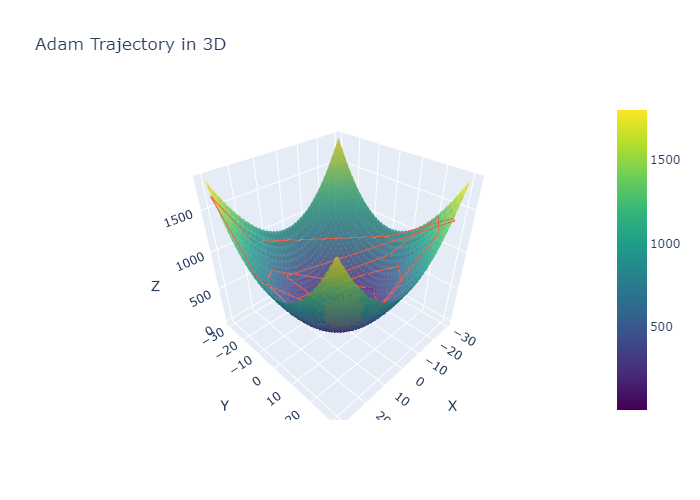

In [20]:
best, xslist_bbi, trajectory = adam_optimizer(x0, potential, iterations=test_iterations, **best_par_adam)

# surface data
x = np.linspace(-30, 30, 100)
y = np.linspace(-30, 30, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        Z[i,j] = rastrigin_plot(np.array([X[i,j], Y[i,j]]))[0]

# Create the trajectory
trajectory_x = [pos[0] for pos in trajectory]
trajectory_y = [pos[1] for pos in trajectory]
trajectory_z = [rastrigin_plot(np.array([pos[0], pos[1]]))[0] for pos in trajectory]

surface = go.Surface(x=X, y=Y, z=Z, colorscale='Viridis', opacity=0.8)
trajectory = go.Scatter3d(x=trajectory_x, y=trajectory_y, z=trajectory_z, mode='lines', marker=dict(size=4))
layout = go.Layout(scene=dict(xaxis=dict(title='X'), yaxis=dict(title='Y'), zaxis=dict(title='Z')), title='Adam Trajectory in 3D')
fig = go.Figure(data=[surface, trajectory], layout=layout)
pyo.plot(fig, filename='plotly/Rastrigin-Adam-trajectory-in-3D.html')
pio.write_image(fig, 'plotly/Rastrigin-Adam-trajectory-in-3D.png')
display(Image(filename='plotly/Rastrigin-Adam-trajectory-in-3D.png'))

[View Adam performans on Rastrigin function made in Plotly](https://github.com/dariayakovchuk/Optimization-Mini-Project/plotly/Rastrigin-Adam-trajectory-in-3D.html)